## **08.a Binning**,
#### Authors: **Amanda Farias (afariassantos2@gmail.com), Iago Lopes (iagolops2012@gmail.com)**,
#### Creation date: **09/13/2024**,
#### Last Verifed to Run: **11/19/2024** (by @iagolops),


The objective of this notebook is to obtain the redshift distribution of the dataset (through a histogram for the true redshift and through a PDF for the observed redshift). Then, the dataset will be binned according to the __[LSST DESC SRD](https://arxiv.org/pdf/1809.01669)__. The lens sample, using the MagLim cut, will be divided into 5 bins with a width of $\Delta z = 0.2$, ranging from 0.2 to 1.2. The source sample will be divided into 5 bins, each containing an equal number of galaxies.   

#### Note: This notebook is not ready yet. We will change the binning functions for RAIL functions!

In [1]:
from enum import Enum
import numpy as np 
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy import integrate
from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from rail.estimation.algos.true_nz import TrueNZHistogrammer
from rail.core.stage import RailStage
import scipy
import tables_io
from scipy.special import erf
import h5py
import pandas as pd
import qp
from scipy.interpolate import UnivariateSpline
from rail.evaluation.dist_to_dist_evaluator import DistToDistEvaluator

from rail.core.data import (
    QPHandle,
    TableHandle,
    Hdf5Handle,
)

import gc
from Binnig import *

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

path = '/global/u1/i/iago/roman_rubin_samples/'

## Loading the dataset from notebook 04a
This dataset was evaluated in notebook 04a and it contains the true redshift, observed redshift and the PDFs of each galaxy. 

<div class="alert alert-block alert-danger">
<b>attention:</b> change the dataset - just a temp </div>

In [3]:
############## Download the catalog with the photo-z #############

result = DS.read_file('pdfs_data', QPHandle, 
                      f'{path}/results_y1/output_estimate_a_roman_fzb_y1_10sig.hdf5')

############### Max redshift ##############
z_max = result().build_tables()['meta']['xvals'][0][-1]

############ X values for plot ############
zgrid = np.linspace(0, z_max, 301)
    
################## PDFS ##################
pdfs = result().build_tables()['data']['yvals']

########## Median or mode of PDF ##########
mode = result().mode(zgrid)

#### Array of photo-z with 132891 galaxies
zphot  = np.array([valor for sublista in mode for valor in sublista])

##############################################
################ True redshift ###############
##############################################

catalog = pd.read_csv(f'{path}/roman_rubin_y1_a_test_10sig.csv', sep=' ')
catalog['zphot'] = zphot
ztrue = catalog['redshift']

## LENS MagLim

In [14]:
a_vector = [3.0,3.5,4.0,4.5]
b_vector = [17.5,18.0,18.5,19.0]

### Looking metrics for all cuts

In [15]:
%%capture
metrics = {}
for a in a_vector:
    for b in b_vector:
        mask = catalog['mag_i_lsst'] < b + a*catalog['zphot']
        total = len(catalog[mask]['redshift'])

        create_filtered_hdf5_files(mask, path, zphot)
        process_bins()
        create_histograms()
        sizes = []
        
        for i in range(5):
            mask_iter = (catalog['mag_i_lsst'] < b + a*catalog['zphot']) & (catalog["mag_i_lsst"] > 17.5) & (catalog['zphot'] > 0.2 + 0.2*i) & (catalog['zphot'] < 0.4 + 0.2*i)
            zphot_lens = zphot[mask_iter]
            pdfs_mask = result.data[mask_iter]
            tables = pdfs_mask.build_tables()
            sizes.append(tables['data']['yvals'].shape[0])
            pdfs_qp = DS.add_data(key=f'maglim_pdfs_{i}', handle_class=QPHandle, data=pdfs_mask)
            
    
            naive_stack_lens_phot  = NaiveStackSummarizer.make_stage(zmin=0.0, zmax=3.0, nzbins=301, nsamples = 25, hdf5_groupname='', chunk_size=400000, name=f'naive_stack_lens_phot_bin{i}')
            naive_results_lens_phot = naive_stack_lens_phot.summarize(pdfs_qp)

        metrics[f'{a}_{b}'] = metris_sample(num_bins=5, param=(a,b), sizes=sizes)

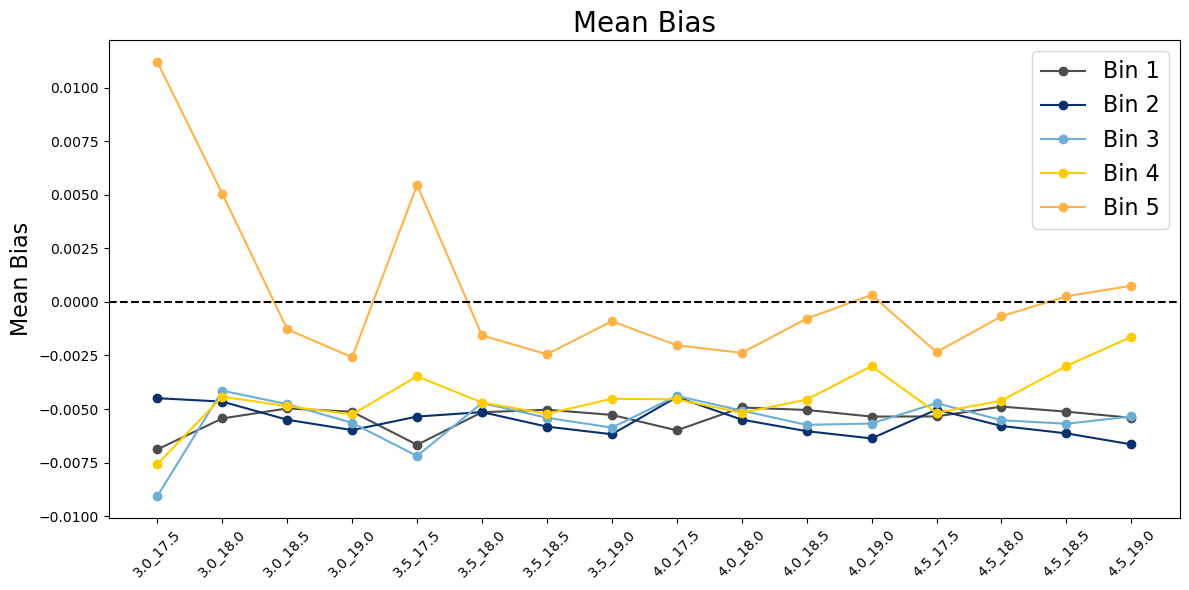

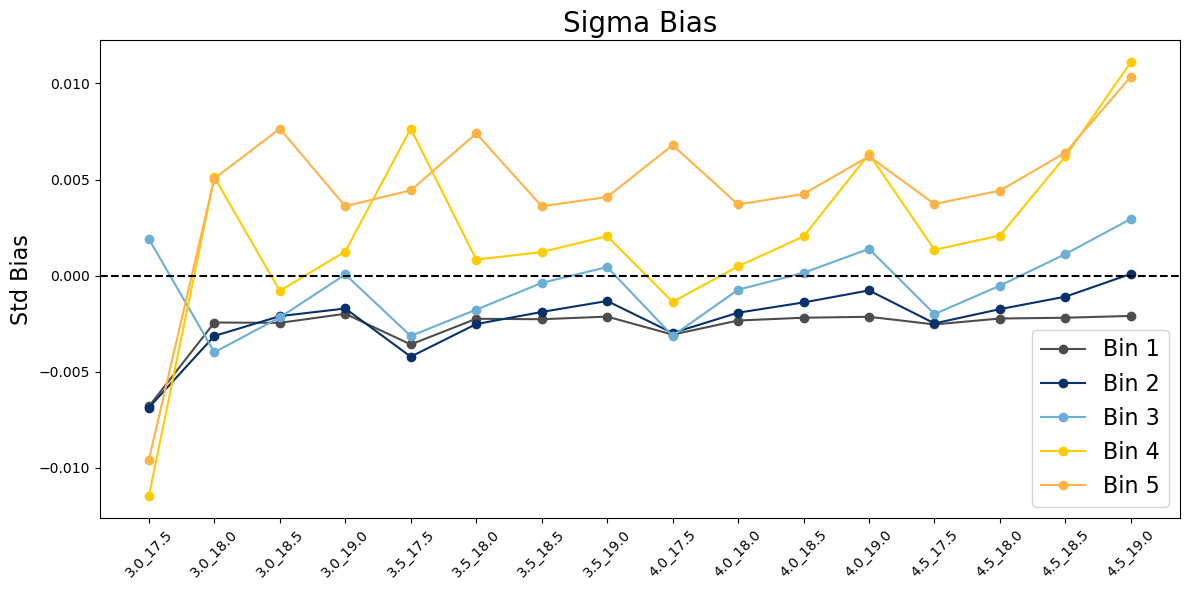

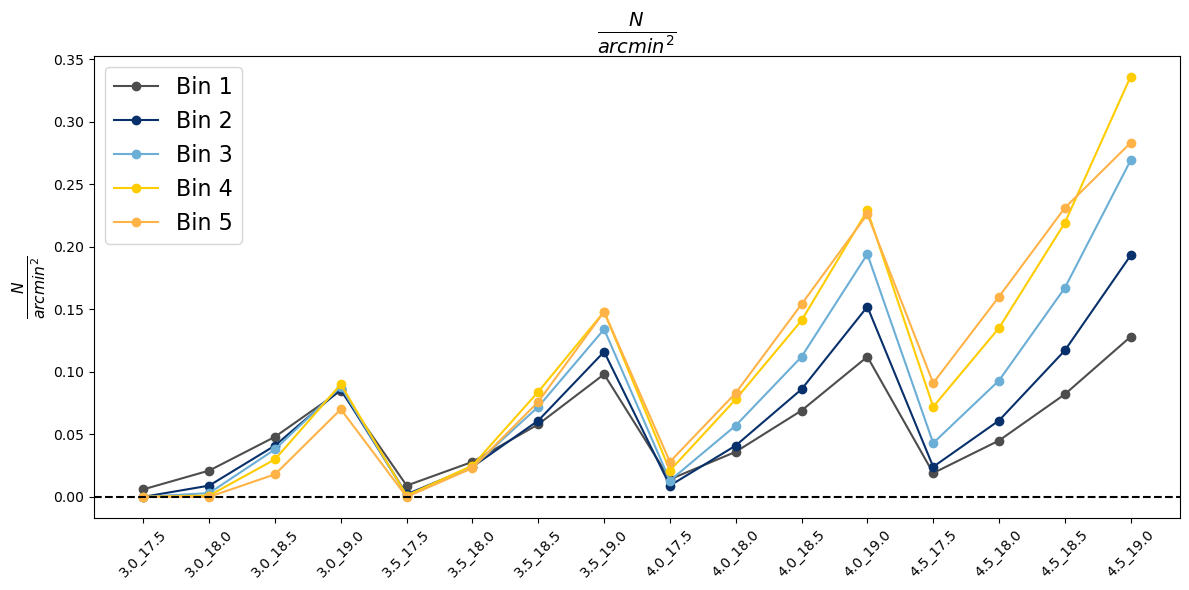

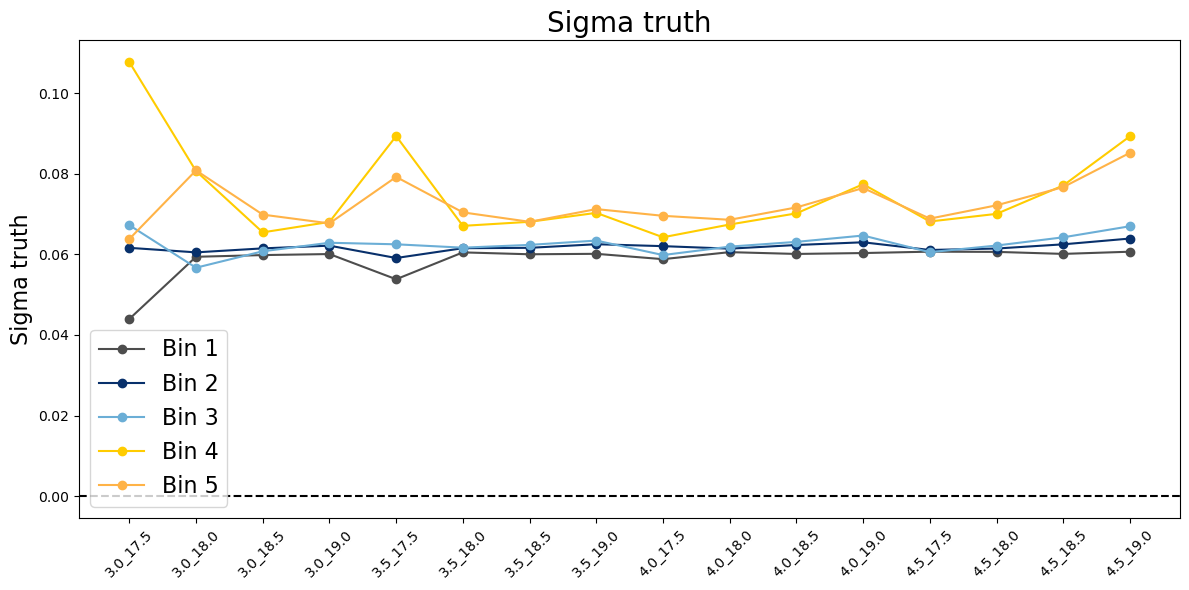

In [16]:
colors = ['#4d4d4d', '#08306b', '#6baed6', '#ffcc00', '#ffb347'] 

def plot_metrics(metric_index, title, ylabel):
    plt.figure(figsize=(12, 6))

    # Para cada bin, plotamos uma curva diferente
    for i in range(5):
        x_values = []  # Lista para os rótulos das combinações (a, b)
        y_values = []  # Lista para os valores de cada métrica

        # Itera sobre todas as combinações de a e b
        for a in a_vector:
            for b in b_vector:
                # Adiciona a combinação e o valor da métrica correspondente
                x_values.append(f'{a}_{b}')
                y_values.append(metrics[f'{a}_{b}'][metric_index][i])  # Valor do bin i

        # Plotando a curva para o bin i
        plt.plot(x_values, y_values, color=colors[i], marker='o', label=f'Bin {i+1}')

    # Configurações do gráfico
    plt.axhline(ls='--',color='black')
    plt.title(title,fontsize=20)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(rotation=45)  # Rotaciona os rótulos para evitar sobreposição
    plt.legend(loc='best', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plotando o gráfico de Mean Bias
plot_metrics(
    metric_index=0, 
    title='Mean Bias', 
    ylabel='Mean Bias'
)

# Plotando o gráfico de Std Bias
plot_metrics(
    metric_index=1, 
    title='Sigma Bias', 
    ylabel='Std Bias'
)

plot_metrics(
    metric_index=2, 
    title=r'$\frac{N}{arcmin^2}$', 
    ylabel=r'$\frac{N}{arcmin^2}$'
)

plot_metrics(
    metric_index=3, 
    title=r'Sigma truth', 
    ylabel=r'Sigma truth'
)


### Binning for each sample

Process 0 running estimator on chunk 0 - 1836
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 88
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 56
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 29
Inserting handle into data store.  true_NZ_true_nz_lens_4: inprogress_true_NZ_true_nz_lens_4.hdf5, true_nz_lens_4
Process 0 running estimator on chunk 0 - 19
Inserting handle into data store.  true_NZ_true_nz_lens_5: inprogress_true_NZ_true_nz_lens_5.hdf5, true_nz_lens_5
Process 0 running estimator on chunk 0 - 1834
Inserting handle into data store.  output_naive_stack_lens_phot_bin0: inprogress_output_naive_stack_lens_phot_bin0.hdf5, naive_stack_lens_phot_bin0
Inserting hand

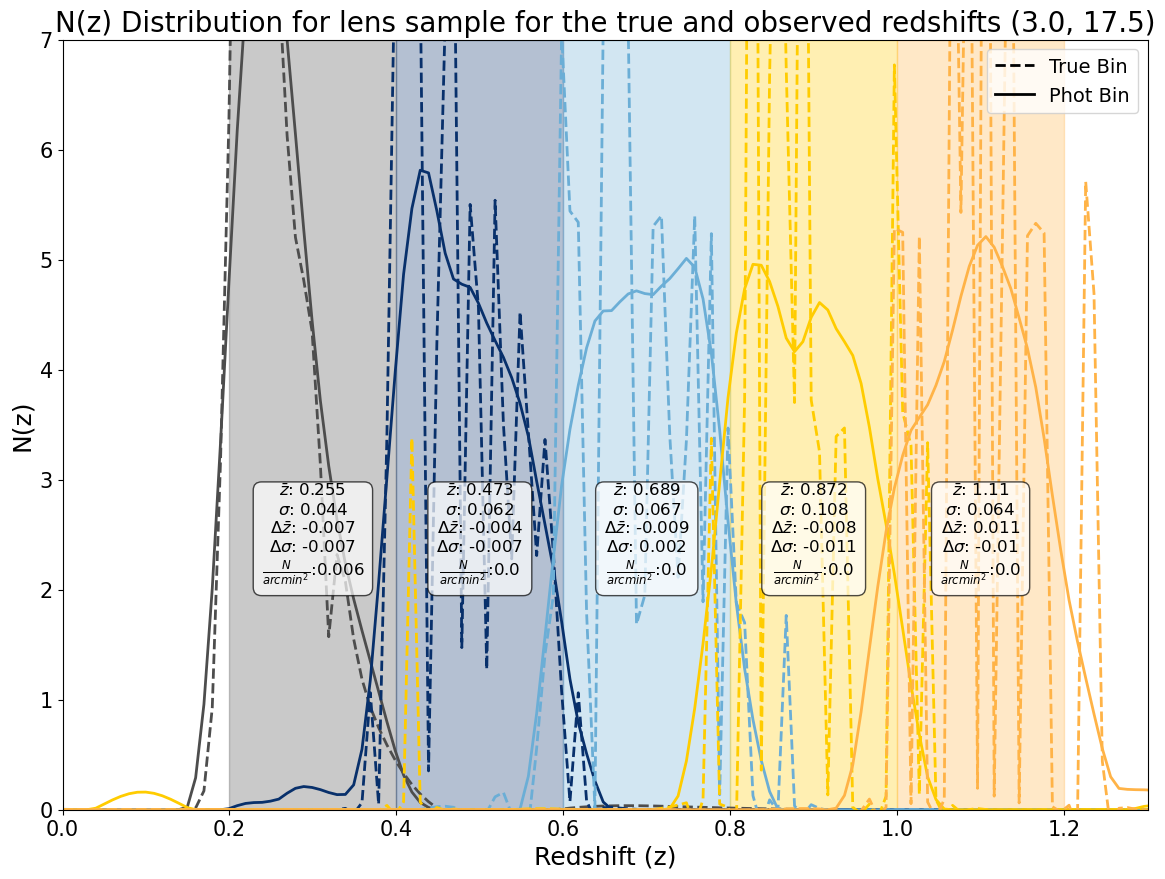

Process 0 running estimator on chunk 0 - 6670
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 2850
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 927
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 277
Inserting handle into data store.  true_NZ_true_nz_lens_4: inprogress_true_NZ_true_nz_lens_4.hdf5, true_nz_lens_4
Process 0 running estimator on chunk 0 - 107
Inserting handle into data store.  true_NZ_true_nz_lens_5: inprogress_true_NZ_true_nz_lens_5.hdf5, true_nz_lens_5
Process 0 running estimator on chunk 0 - 6668
Inserting handle into data store.  output_naive_stack_lens_phot_bin0: inprogress_output_naive_stack_lens_phot_bin0.hdf5, naive_stack_lens_phot_bin0
Inserting

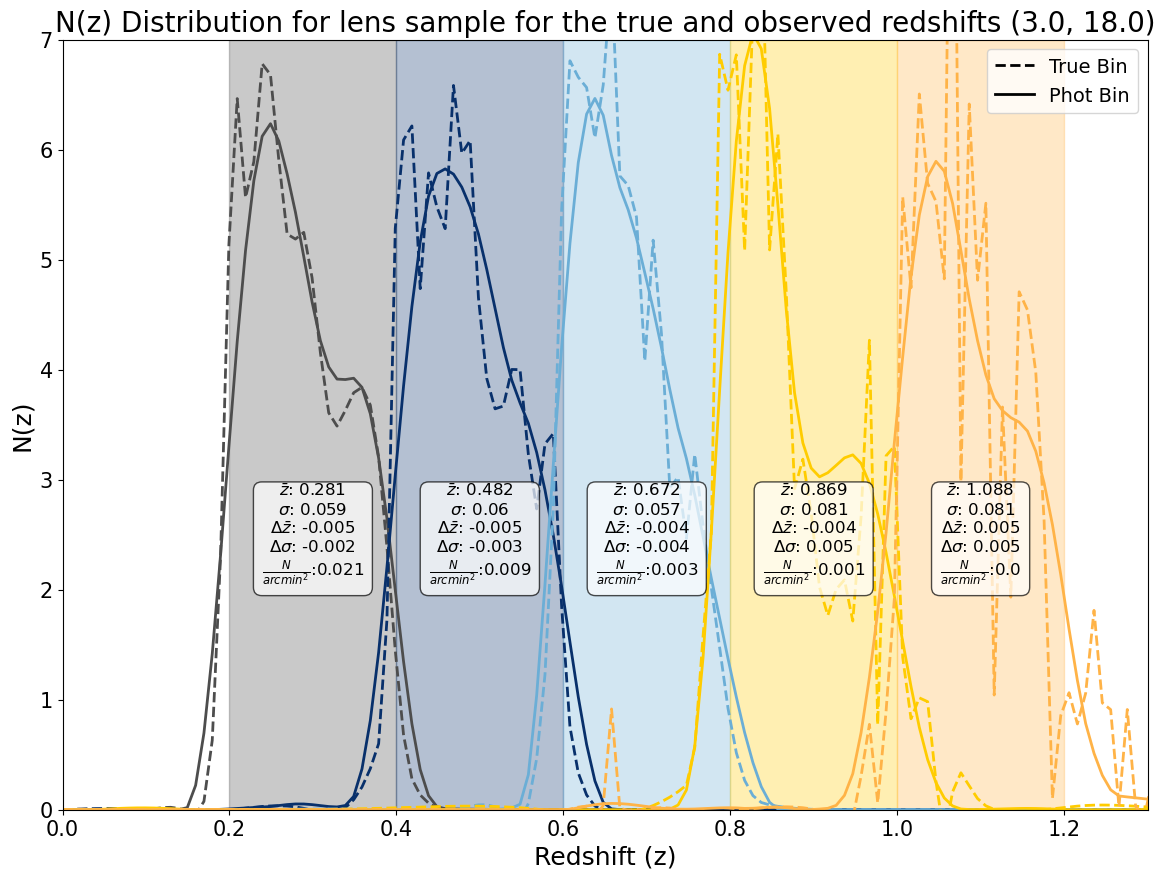

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 14968
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 12814
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 11912
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 9547
Inserting handle into data store.  true_NZ_true_nz_lens_4: inprogress_true_NZ_true_nz_lens_4.hdf5, true_nz_lens_4
Process 0 running estimator on chunk 0 - 5720
Inserting handle into data store.  true_NZ_true_nz_lens_5: inprogress_true_NZ_true_nz_lens_5.hdf5, true_nz_lens_5
Process 0 running estimator on chunk 0 - 149

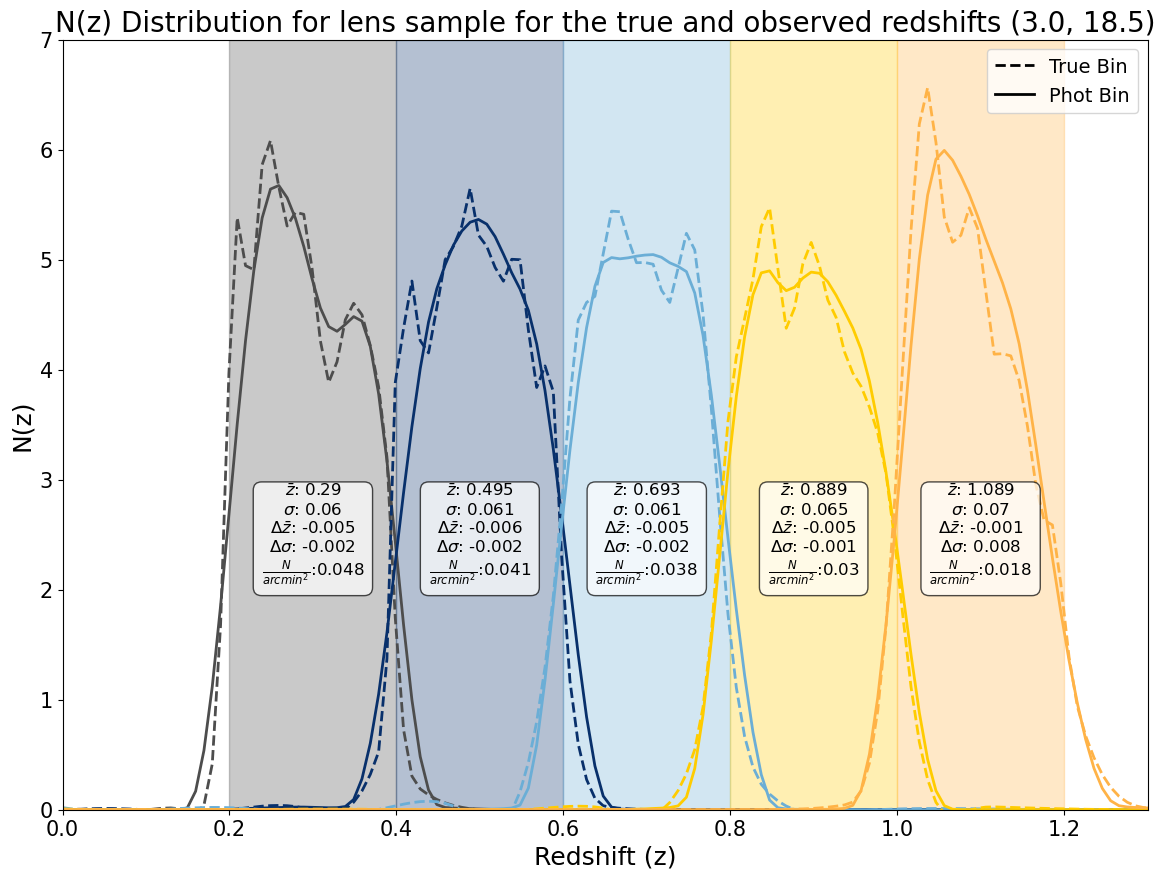

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 26818
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 26931
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 27687
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 28395
Inserting handle into data store.  true_NZ_true_nz_lens_4: inp

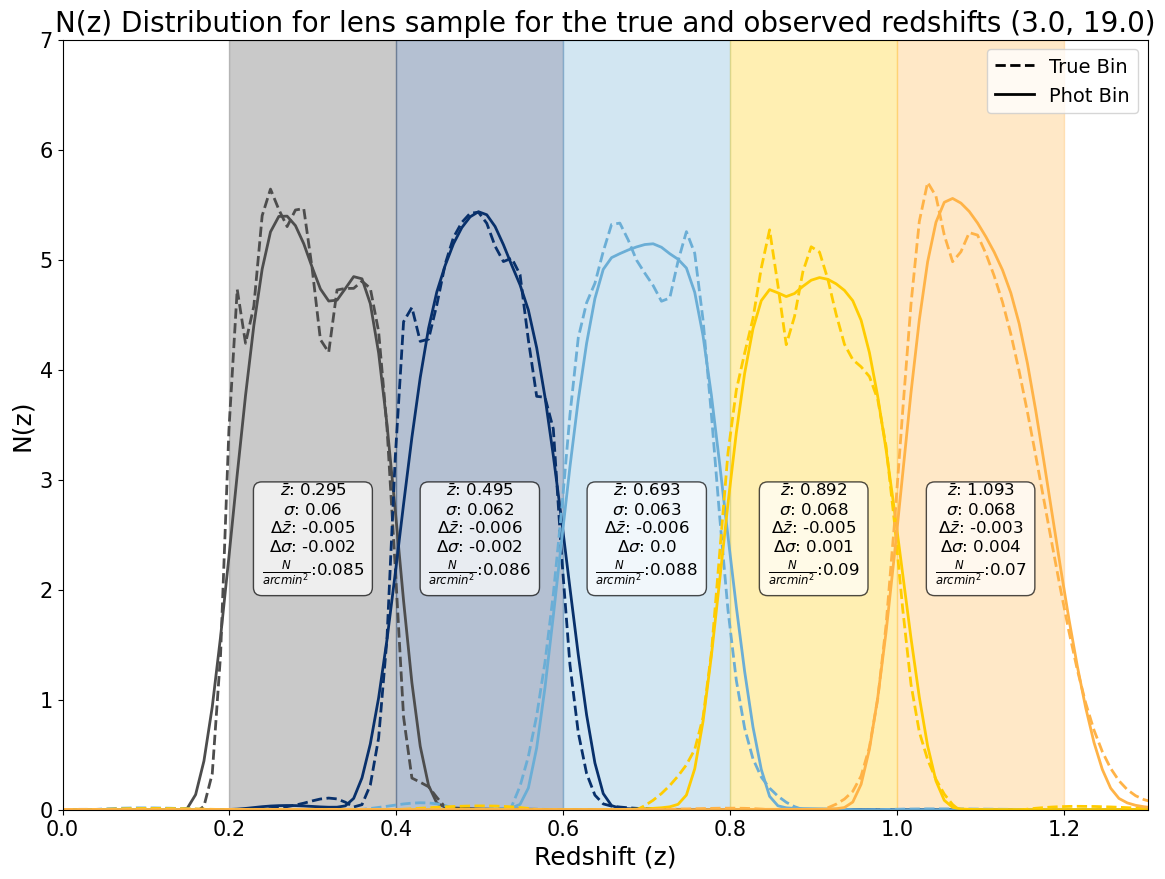

Process 0 running estimator on chunk 0 - 2881
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 569
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 240
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 187
Inserting handle into data store.  true_NZ_true_nz_lens_4: inprogress_true_NZ_true_nz_lens_4.hdf5, true_nz_lens_4
Process 0 running estimator on chunk 0 - 114
Inserting handle into data store.  true_NZ_true_nz_lens_5: inprogress_true_NZ_true_nz_lens_5.hdf5, true_nz_lens_5
Process 0 running estimator on chunk 0 - 2879
Inserting handle into data store.  output_naive_stack_lens_phot_bin0: inprogress_output_naive_stack_lens_phot_bin0.hdf5, naive_stack_lens_phot_bin0
Inserting 

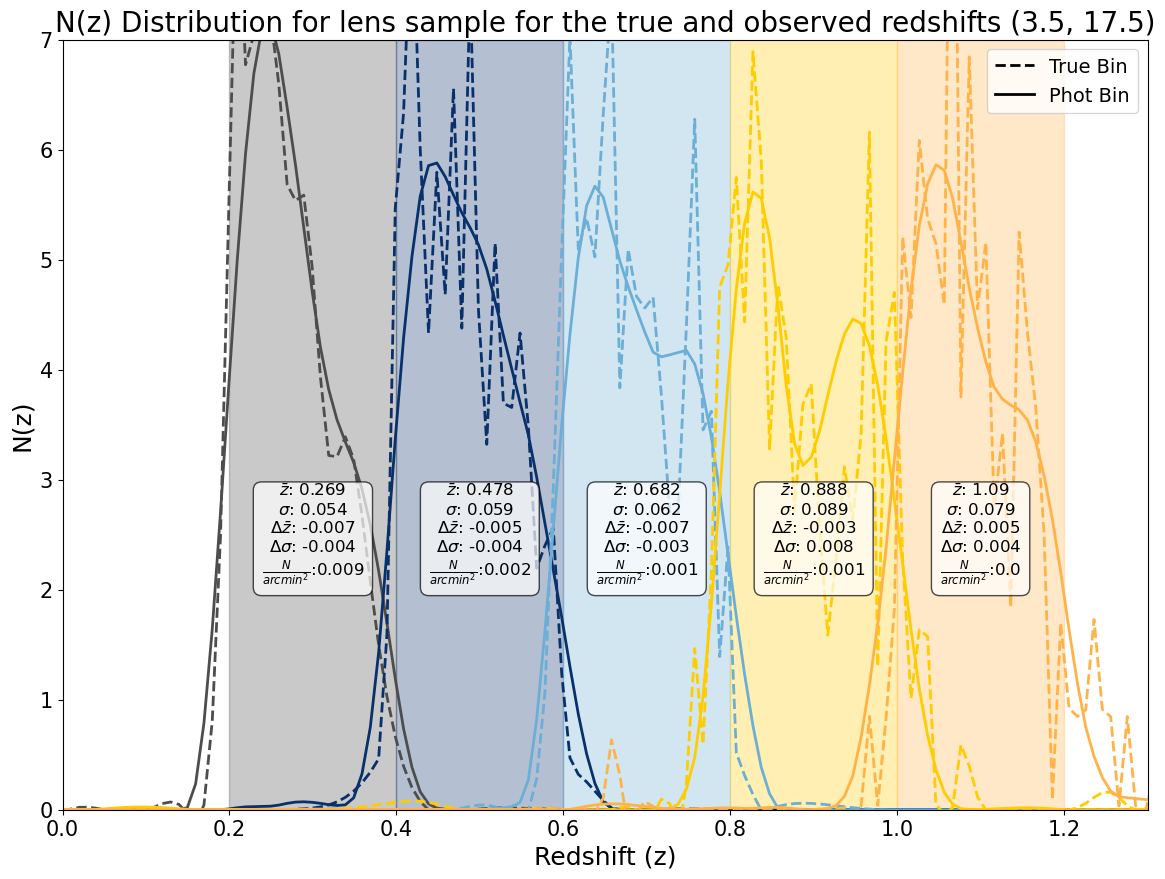

Process 0 running estimator on chunk 0 - 8766
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 7496
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 7622
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 8014
Inserting handle into data store.  true_NZ_true_nz_lens_4: inprogress_true_NZ_true_nz_lens_4.hdf5, true_nz_lens_4
Process 0 running estimator on chunk 0 - 7292
Inserting handle into data store.  true_NZ_true_nz_lens_5: inprogress_true_NZ_true_nz_lens_5.hdf5, true_nz_lens_5
Process 0 running estimator on chunk 0 - 8764
Inserting handle into data store.  output_naive_stack_lens_phot_bin0: inprogress_output_naive_stack_lens_phot_bin0.hdf5, naive_stack_lens_phot_bin0
Insert

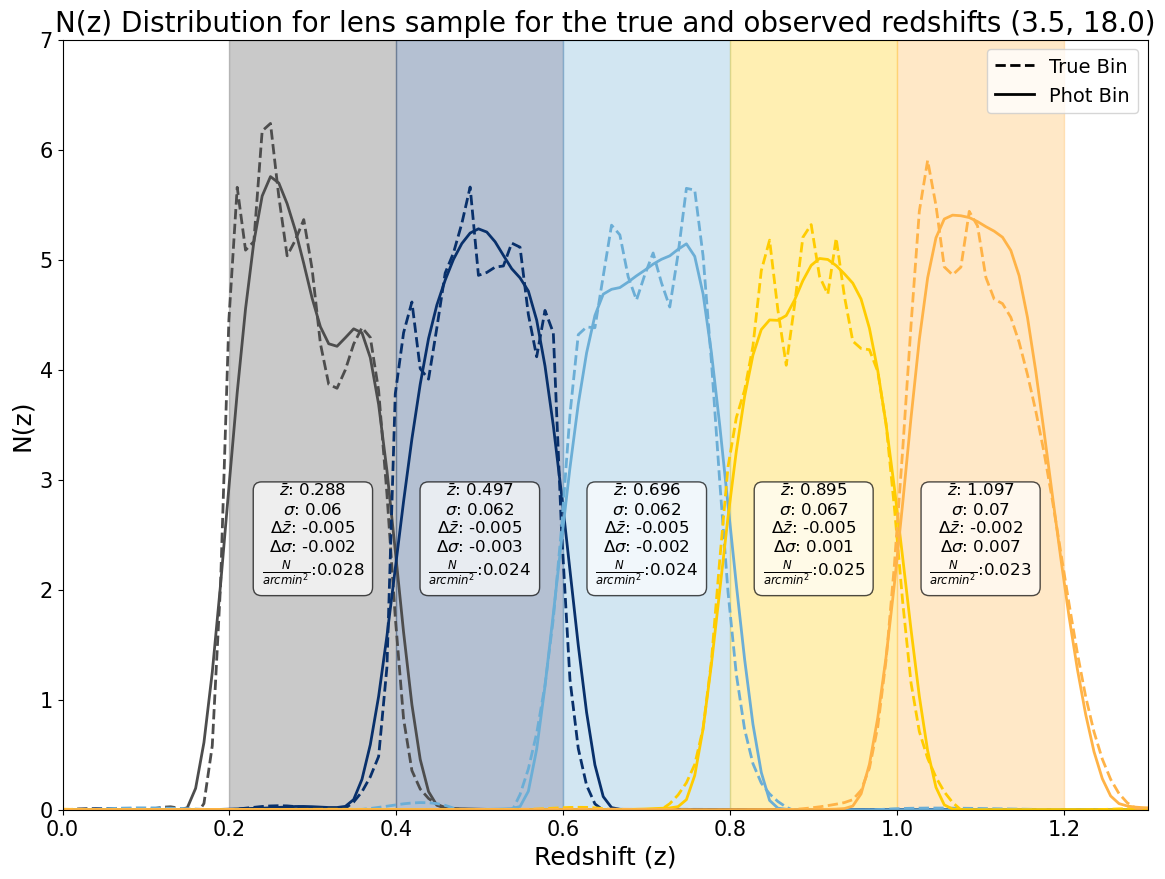

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 18183
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 19188
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 22631
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 26539
Inserting handle into data store.  true_NZ_true_nz_lens_4: inprogress_true_NZ_true_nz_lens_4.hdf5, true_nz_lens_4
Process 0 running estimator on chunk 0 - 10000
Pro

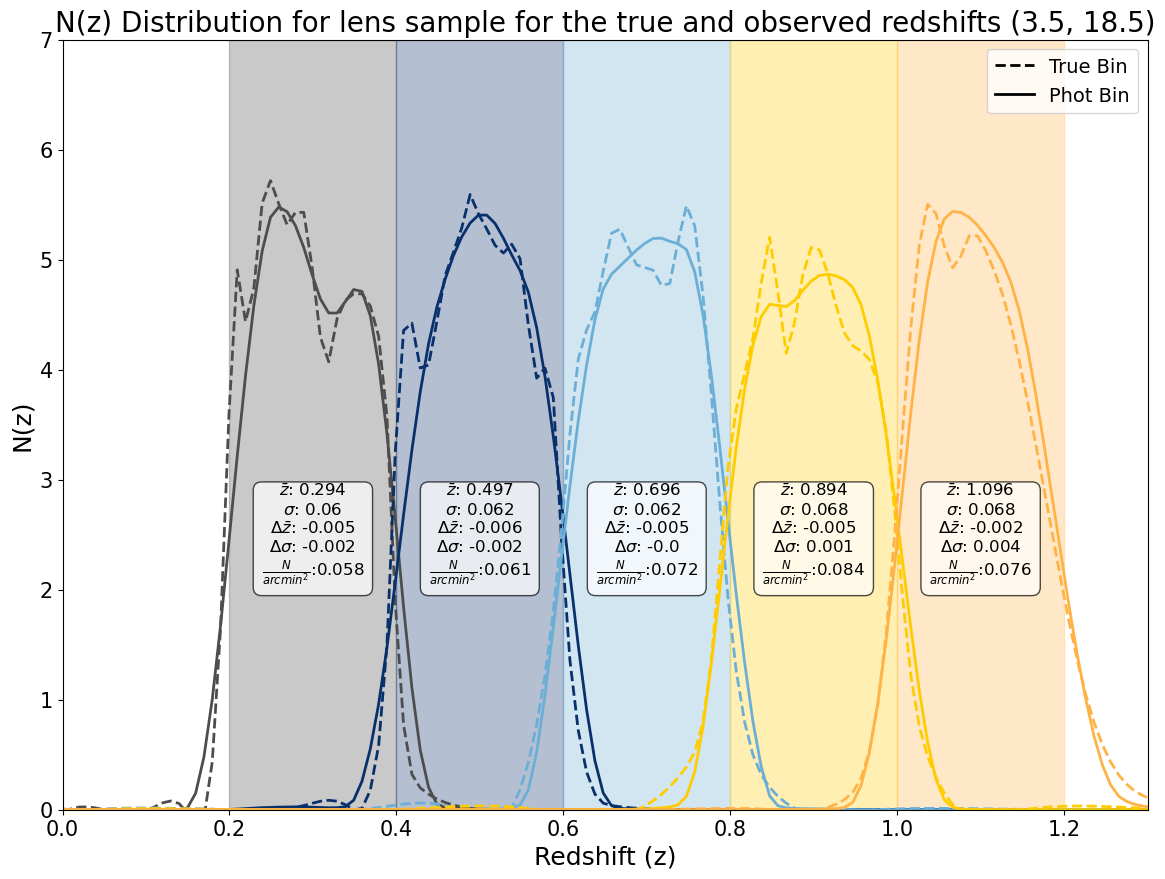

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 30975
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 36654
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 40000
Process 0 running estimator on chunk 40000 - 42183
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process

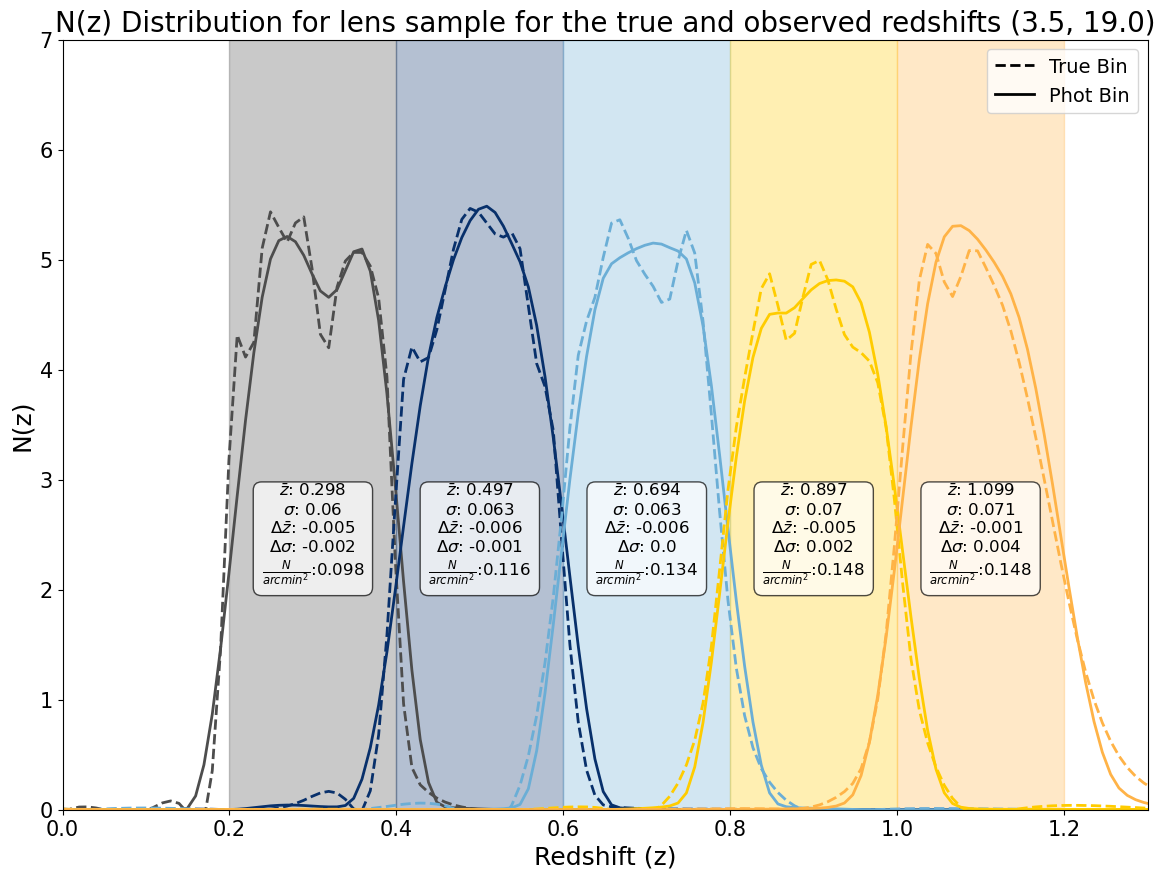

Process 0 running estimator on chunk 0 - 4378
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 2883
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 4018
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 6617
Inserting handle into data store.  true_NZ_true_nz_lens_4: inprogress_true_NZ_true_nz_lens_4.hdf5, true_nz_lens_4
Process 0 running estimator on chunk 0 - 8892
Inserting handle into data store.  true_NZ_true_nz_lens_5: inprogress_true_NZ_true_nz_lens_5.hdf5, true_nz_lens_5
Process 0 running estimator on chunk 0 - 4376
Inserting handle into data store.  output_naive_stack_lens_phot_bin0: inprogress_output_naive_stack_lens_phot_bin0.hdf5, naive_stack_lens_phot_bin0
Insert

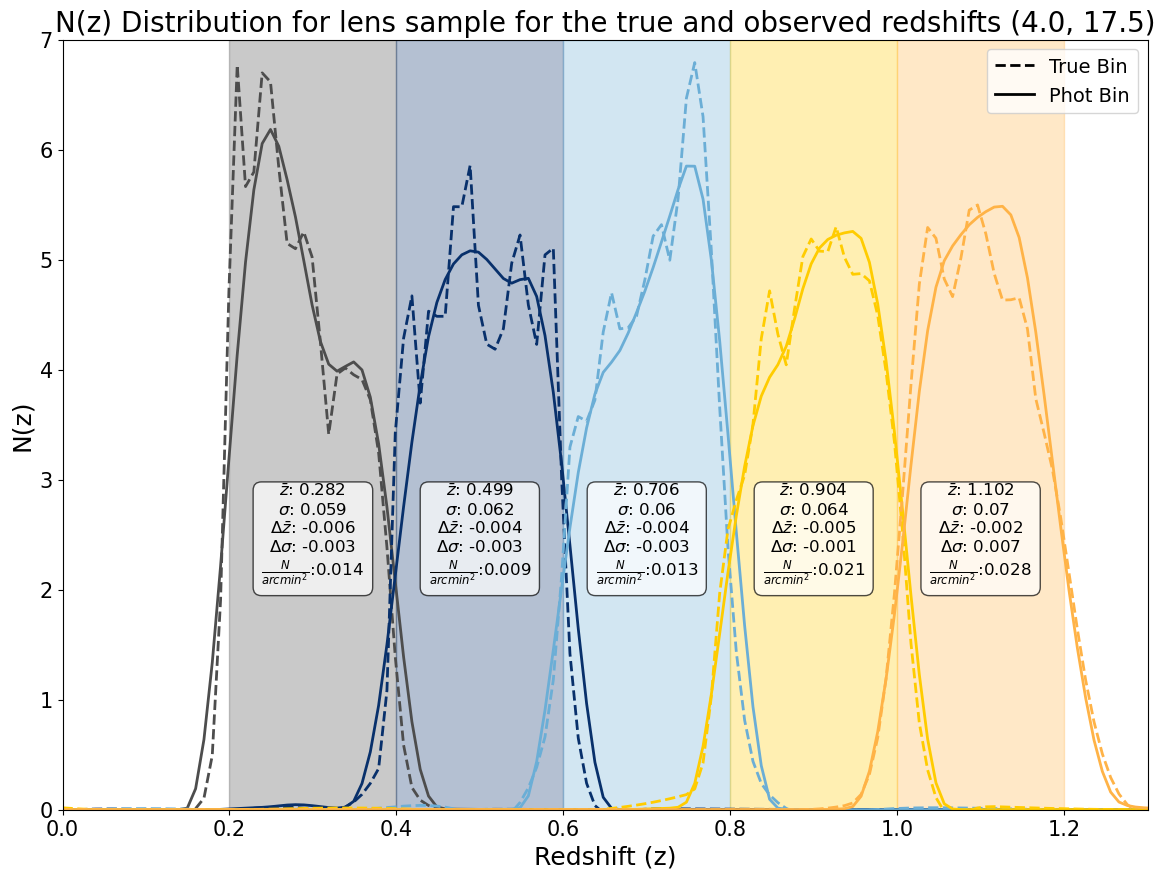

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 11232
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 12864
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 17894
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 24659
Inserting handle into data store.  true_NZ_true_nz_lens_4: inprogress_true_NZ_true_nz_lens_4.hdf5, true_nz_lens_4
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Pro

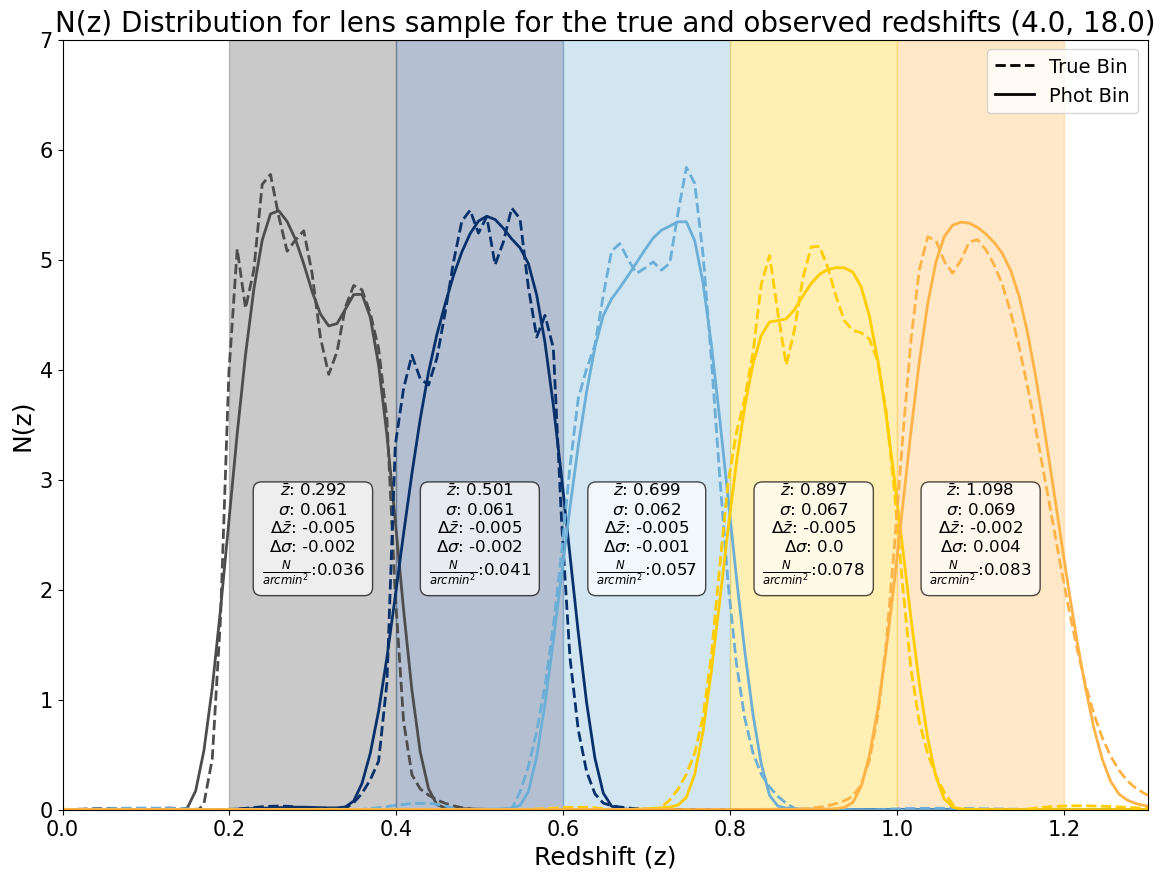

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 21841
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 27060
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 35342
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 r

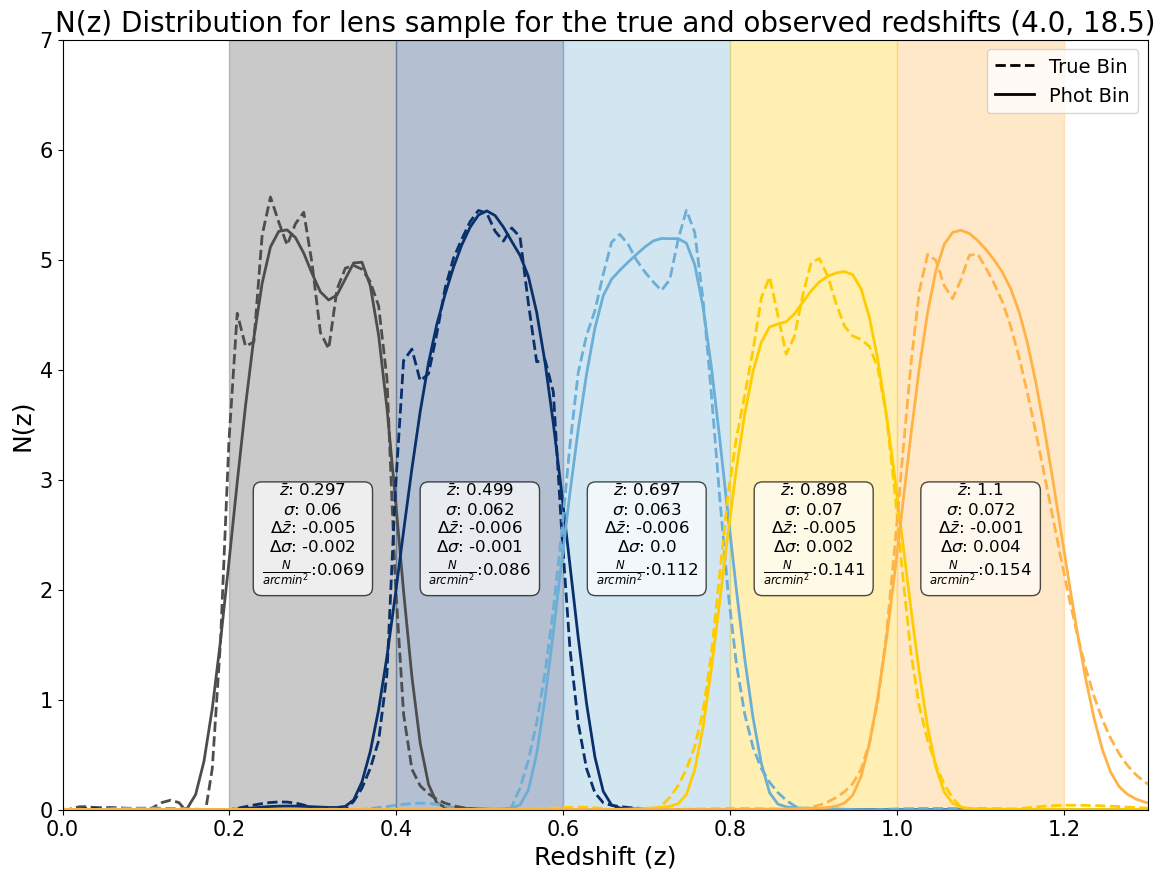

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 35413
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 40000
Process 0 running estimator on chunk 40000 - 47938
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 40000
Process 0 running estimator on chunk 40000 - 50000
Process 0 running estimator on chunk 50000 - 60000
Process 0 running e

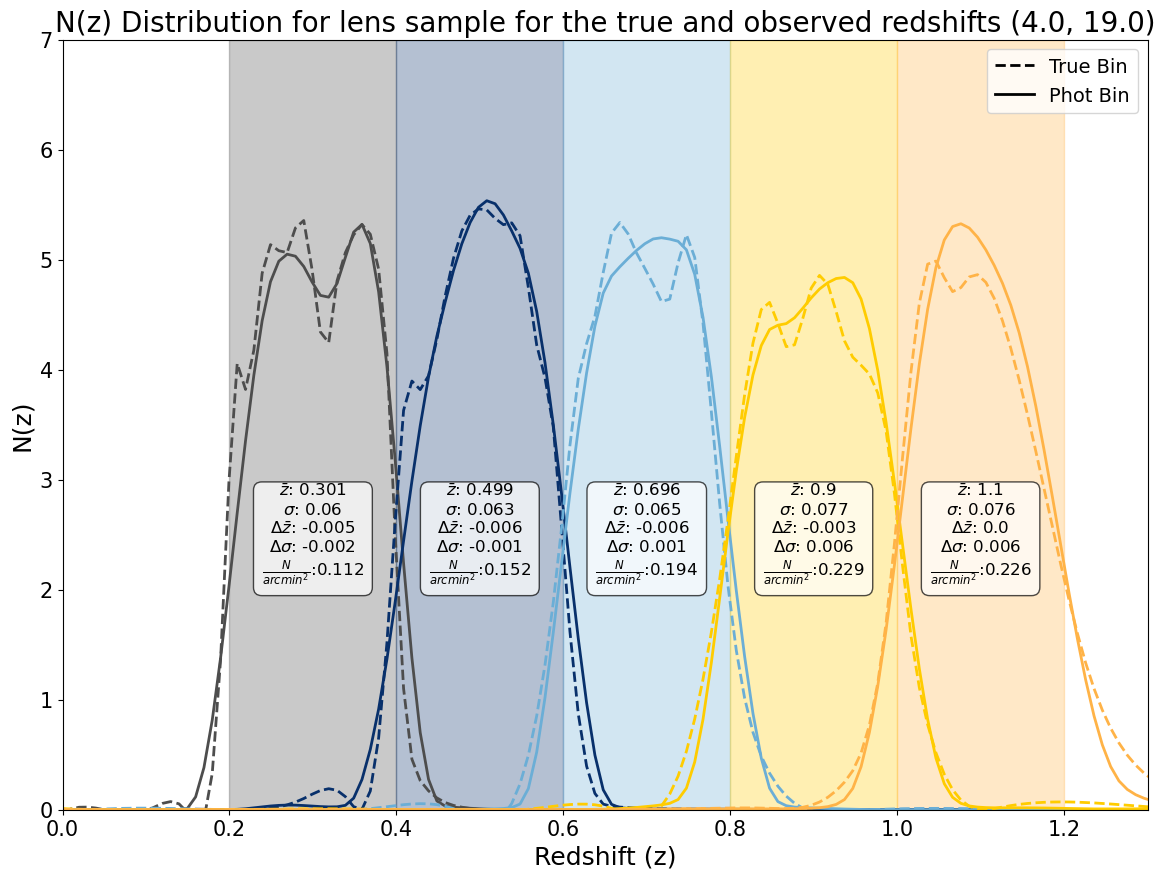

Process 0 running estimator on chunk 0 - 6075
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 7662
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 13523
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 22632
Inserting handle into data store.  true_NZ_true_nz_lens_4: inprogress_true_NZ_true_nz_lens_4.hdf5, true_nz_lens_4
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 28544
Inserting handle into data store.  true_NZ_true_nz_lens_

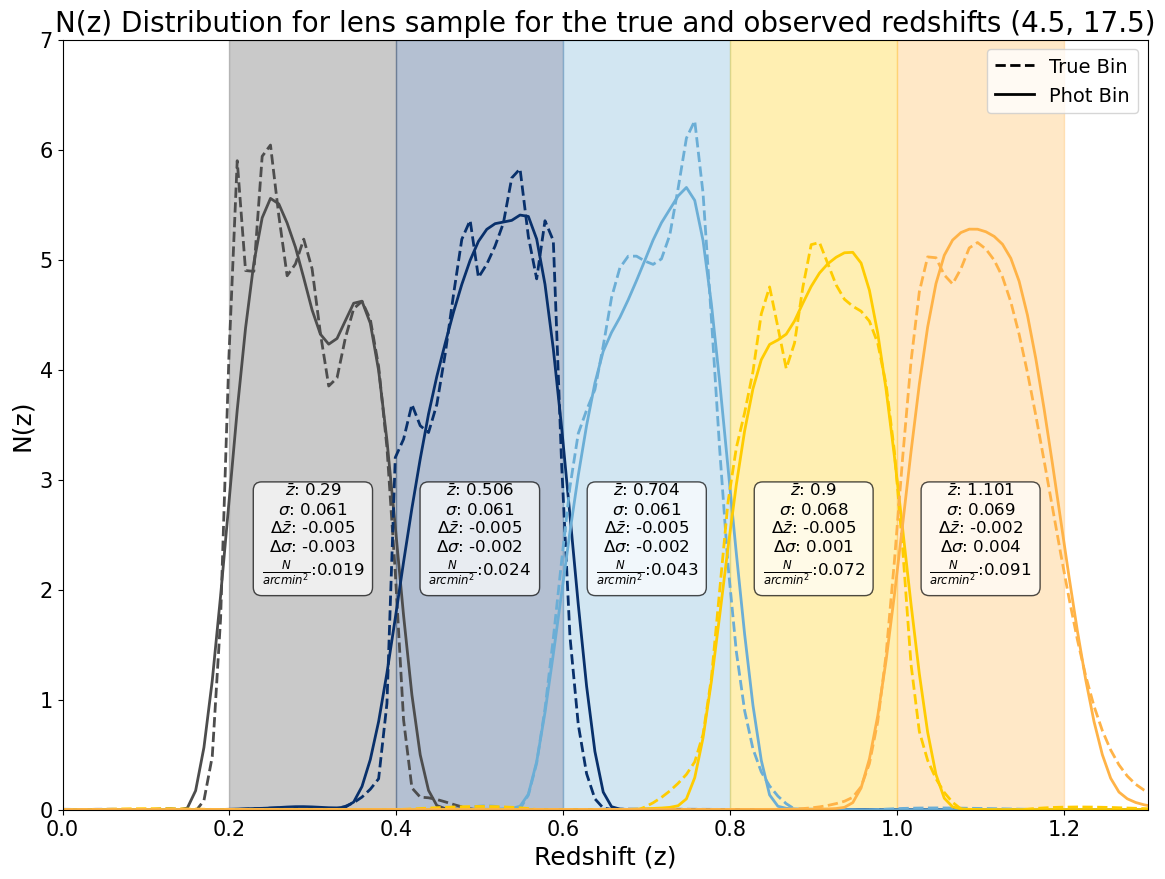

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 14138
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 19269
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 29423
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 40000
Process 0 running estimator on chunk 40000 - 42504
Inserting handle into data store.  true_NZ_true_nz_lens_4: inp

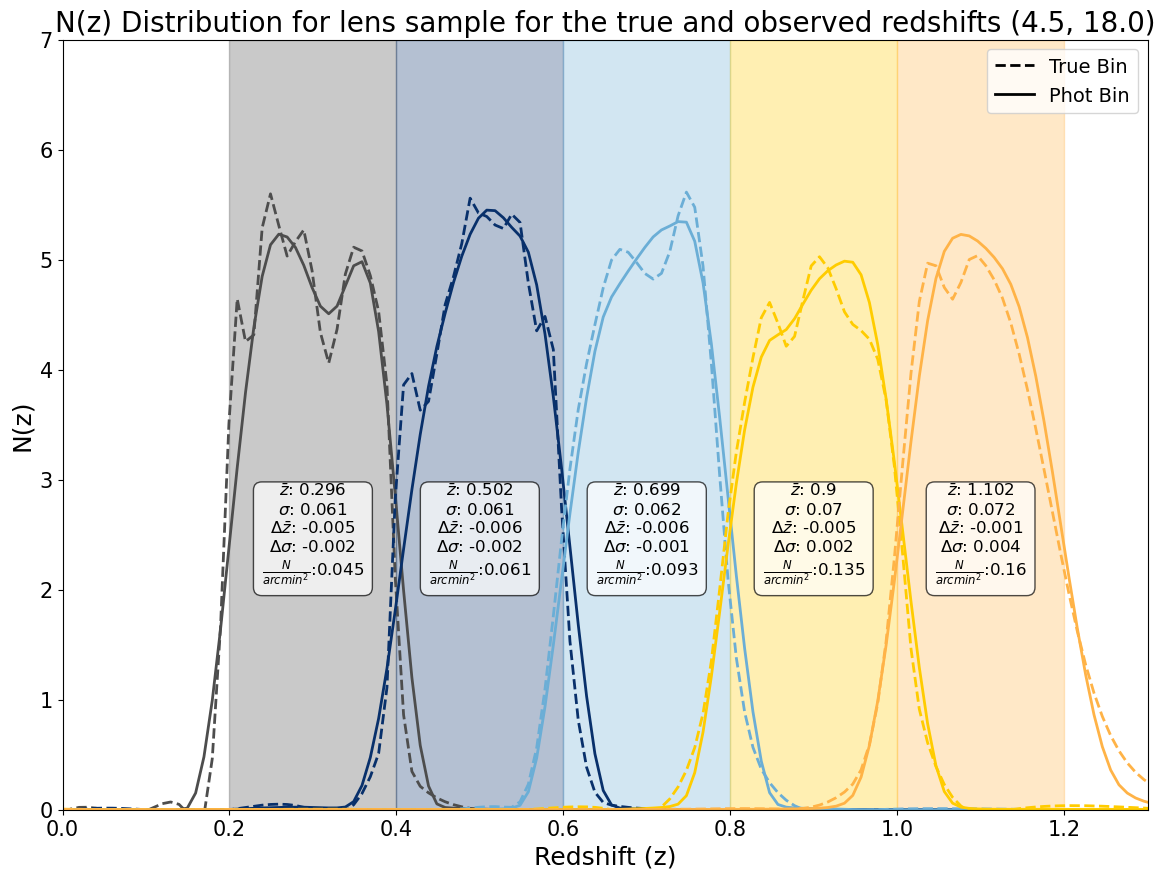

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 25916
Inserting handle into data store.  true_NZ_true_nz_lens_1: inprogress_true_NZ_true_nz_lens_1.hdf5, true_nz_lens_1
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 36867
Inserting handle into data store.  true_NZ_true_nz_lens_2: inprogress_true_NZ_true_nz_lens_2.hdf5, true_nz_lens_2
Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 40000
Process 0 running estimator on chunk 40000 - 50000
Process 0 running estimator on chunk 50000 - 52576
Inserting handle into data store.  true_NZ_true_nz_lens_3: inprogress_true_NZ_true_nz_lens_3.hdf5, true_nz_lens_3
Process

KeyboardInterrupt: 

In [19]:
for a in a_vector:
    for b in b_vector:
        mask = catalog['mag_i_lsst'] < b + a*catalog['zphot']
        total = len(catalog[mask]['redshift'])

        create_filtered_hdf5_files(mask, path, zphot)
        process_bins()
        create_histograms()
        sizes = []
        
        for i in range(5):
            mask_iter = (catalog['mag_i_lsst'] < b + a*catalog['zphot']) & (catalog["mag_i_lsst"] > 17.5) & (catalog['zphot'] > 0.2 + 0.2*i) & (catalog['zphot'] < 0.4 + 0.2*i)
            zphot_lens = zphot[mask_iter]
            pdfs_mask = result.data[mask_iter]
            tables = pdfs_mask.build_tables()
            sizes.append(tables['data']['yvals'].shape[0])
            pdfs_qp = DS.add_data(key=f'maglim_pdfs_{i}', handle_class=QPHandle, data=pdfs_mask)
            
    
            naive_stack_lens_phot  = NaiveStackSummarizer.make_stage(zmin=0.0, zmax=3.0, nzbins=301, nsamples = 25, hdf5_groupname='', chunk_size=400000, name=f'naive_stack_lens_phot_bin{i}')
            naive_results_lens_phot = naive_stack_lens_phot.summarize(pdfs_qp)

        plot_nz_from_bins(num_bins=5, param=(a,b), sizes=sizes)

## SOURCE Truth

In [4]:
a_final = 3.0
b_final = 19.0

lens_final = catalog[catalog['mag_i_lsst']<a_final*catalog['zphot']+b_final]

mask = ~np.isin(catalog['galaxy_id'], lens_final['galaxy_id'])
source_catalog = catalog[mask]

In [5]:
# Open the original HDF5 file (read mode)
with h5py.File(f'{path}/roman_rubin_y1_a_test_10sig.hdf5', 'r') as old_file:
    # Navigate inside the 'photometry' group in the old file
    if 'photometry' in old_file:
        old_photometry_group = old_file['photometry']
        
        # Get the redshift data from the old file
        if 'zphot' in old_photometry_group:
            redshift_data = old_photometry_group['zphot'][:]
            redshift_data = redshift_data[catalog['mag_i_lsst']>a_final*catalog['zphot']+b_final]
            
            num_galaxies = len(redshift_data)
            
            # Determine the number of galaxies per bin
            num_bins = 5
            galaxies_per_bin = num_galaxies // num_bins
            
            # Get the sorted indices based on redshift
            sorted_indices = np.argsort(redshift_data)
            
            # Loop over each bin from 1 to 5
            for bin_i in range(1, num_bins + 1):
                # Create a new HDF5 file for each bin (write mode)
                with h5py.File(f'roman_rubin_test_binning_src_{bin_i}.hdf5', 'w') as new_file:
                    # Create 'photometry' group in the new file
                    photometry_group = new_file.create_group('photometry')

                    # Determine the start and end indices for the current bin
                    start_index = (bin_i - 1) * galaxies_per_bin
                    end_index = start_index + galaxies_per_bin if bin_i < num_bins else num_galaxies
                    
                    # Get the indices of the galaxies for this bin
                    bin_indices = sorted_indices[start_index:end_index]

                    # List of columns to keep under the 'photometry' group
                    columns_to_keep = [
                        "mag_err_g_lsst", "mag_err_i_lsst", "mag_err_r_lsst", 
                        "mag_err_u_lsst", "mag_err_y_lsst", "mag_err_z_lsst",
                        "mag_g_lsst", "mag_i_lsst", "mag_r_lsst", 
                        "mag_u_lsst", "mag_y_lsst", "mag_z_lsst", 
                        "redshift", "galaxy_id"
                    ]

                    # Loop through the columns and filter based on bin_indices
                    for column in columns_to_keep:
                        if column in old_photometry_group:
                            data = old_photometry_group[column][:]
                            data = data[catalog['mag_i_lsst']>a_final*catalog['zphot']+b_final]
                            filtered_data = data[bin_indices]  # Keep only the rows for the current bin
                            
                            # Rename 'galaxy_id' to 'id' when copying to the new file
                            if column == "galaxy_id":
                                photometry_group.create_dataset("id", data=filtered_data)
                            else:
                                photometry_group.create_dataset(column, data=filtered_data)
                        else:
                            print(f"Column {column} not found in the 'photometry' group.")


In [6]:
# Load redshift data from the HDF5 file
with h5py.File(f'{path}/roman_rubin_y1_a_test_10sig.hdf5', 'r') as old_file:
    # Navigate inside the 'photometry' group in the old file
    if 'photometry' in old_file:
        old_photometry_group = old_file['photometry']
        
        # Access the redshift column
        if 'zphot' in old_photometry_group:
            redshifts = old_photometry_group['zphot'][:]
            redshifts = redshifts[catalog['mag_i_lsst']>a_final*catalog['zphot']+b_final]
            num_galaxies = len(redshifts)
            
            # Sort redshifts and their corresponding indices
            sorted_indices = np.argsort(redshifts)
            sorted_redshifts = redshifts[sorted_indices]
            
            # Determine the number of galaxies per bin
            num_bins = 5
            galaxies_per_bin = num_galaxies // num_bins
            
            # Loop over each bin from 1 to 5
            for bin_num in range(1, num_bins + 1):
                # Determine the start and end indices for the current bin
                start_index = (bin_num - 1) * galaxies_per_bin
                end_index = start_index + galaxies_per_bin if bin_num < num_bins else num_galaxies
                
                # Get the indices of the galaxies for this bin
                bin_indices = sorted_indices[start_index:end_index]
                
                # Assign class IDs for the selected galaxies
                class_ids = np.array([assign_class_id(z) for z in sorted_redshifts[start_index:end_index]])

                # Function to create each bin file
                def create_bin_file(bin_num, bin_indices, class_ids):
                    output_file = f'output_tomo_binned_src_{bin_num}.hdf5'
                    
                    # Create the new HDF5 file and store the 'row_index' and 'class_id'
                    with h5py.File(output_file, 'w') as outfile:
                        outfile.create_dataset('row_index', data=bin_indices)
                        outfile.create_dataset('class_id', data=class_ids)
                    
                    print(f"HDF5 file '{output_file}' created successfully!")

                # Call the function to create the output bin file
                create_bin_file(bin_num, bin_indices, class_ids)

HDF5 file 'output_tomo_binned_src_1.hdf5' created successfully!
HDF5 file 'output_tomo_binned_src_2.hdf5' created successfully!
HDF5 file 'output_tomo_binned_src_3.hdf5' created successfully!
HDF5 file 'output_tomo_binned_src_4.hdf5' created successfully!
HDF5 file 'output_tomo_binned_src_5.hdf5' created successfully!


In [7]:
%%capture
# Loop over the 5 tomographic bins
for i in range(5):
    
    true_nz_file = f'roman_rubin_test_binning_src_{i+1}.hdf5'
    true_nz = DS.read_file('true_nz', path=true_nz_file, handle_class=TableHandle)
    
    # Create the histogram stage for the ith bin
    nz_hist = TrueNZHistogrammer.make_stage(
        name=f'true_nz_src_{i+1}',  # String formatting to properly name each histogram stage
        hdf5_groupname='photometry',
        redshift_col='redshift',
        zmin=0.0,
        zmax=3.0,
        nzbins=301
    )
    
    # Load the corresponding tomographic bin file
    tomo_file = f"output_tomo_binned_src_{i+1}.hdf5"  # Ensure correct file name for each bin
    tomo_bins = DS.read_file('tomo_bins', path=tomo_file, handle_class=TableHandle)
    
    # Run the histogram for this bin
    out_hist = nz_hist.histogram(true_nz, tomo_bins)
    
    # Optionally, save or inspect the output histogram for each bin
    # e.g., print or save the output
    print(f"Histogram for bin {i+1} created successfully.")

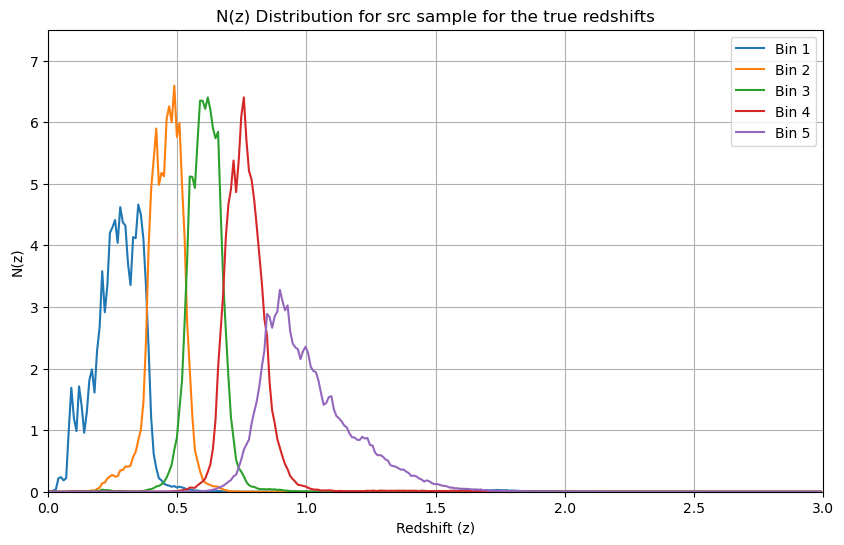

In [8]:
# Function to read and plot results from each bin file
def plot_nz_from_bins(num_bins):
    plt.figure(figsize=(10, 6))  # Create a new figure for plotting
    
    for bin_num in range(1, num_bins + 1):
        # Read the data from the HDF5 file
        input_file = qp.read(f'true_NZ_true_nz_src_{bin_num}.hdf5')
        
        y_true = input_file.objdata()['pdfs'][0]
        x_true = input_file.metadata()['bins'][0]

        cs = UnivariateSpline(x_true[:-1], y_true)
        cs.set_smoothing_factor(8) # adjust the smoothing of ztrue here !!!!

        plt.plot(x_true[:-1], y_true, label=f'Bin {bin_num}')
            
  
    # Customizing the plot
    plt.xlabel('Redshift (z)')
    plt.ylabel('N(z)')
    plt.title('N(z) Distribution for src sample for the true redshifts')
    plt.legend()
    plt.grid()
    plt.ylim(0, 7.5)
    plt.xlim(0, 3.0)
    plt.show()

# Call the function to plot N(z) for 5 bins
plot_nz_from_bins(num_bins=5)

### Observed redshift distribution

The Naive stack method sums the PDFs of all galaxies without considering weights or other parameters. In the ``NaiveStackSummarizer`` from RAIL, the entire redshift range is divided into bins, and the PDFs of all galaxies within each bin are summed. Subsequently, the code normalizes these summed PDFs.

For our configuration, we utilize the redshift range defined by the output, starting from 0 to z_max, and divide this range into 300 bins.

For a more detailed explanation of each component in the ``NaiveStackSummarizer``, please refer to the __[RAIL documentation](https://github.com/LSSTDESC/rail/blob/6f4e15315962b3010dbd52eb2c4e308710df9b87/docs/source/new_rail_stage.rst#L90)__ on GitHub.

Open the output of fzb and select the rows after the maglim

### SOURCE OBS

After deciding which lens sample we are going to use, we can create the source sample first removing galaxies that are in lens.

In [9]:
num_galaxies = len(source_catalog)

# Definir número de bins
num_bins = 5
galaxies_per_bin = num_galaxies // num_bins

# Obter os índices ordenados por redshift fotométrico
sorted_indices = np.argsort(source_catalog['zphot'])

for bin_i in range(num_bins):
    # Determinar índices de início e fim para o bin atual
    start_index = bin_i * galaxies_per_bin
    end_index = start_index + galaxies_per_bin if bin_i < num_bins - 1 else num_galaxies

    # Obter índices das galáxias para este bin
    bin_indices = sorted_indices[start_index:end_index]

    # Obter redshifts fotométricos e PDFs correspondentes
    zphot_src = source_catalog.iloc[bin_indices]['zphot']  
    pdfs_mag = result.data[mask][bin_indices]  # Use loc para indexação por rótulo e aplique a máscara corretamente

    # Adicionar PDFs ao DataStore
    mag_qp = DS.add_data(key='src_pdfs', handle_class=QPHandle, data=pdfs_mag)

    # Configurar o NaiveStackSummarizer
    naive_stack_src_phot = NaiveStackSummarizer.make_stage(
        zmin=0.0, zmax=3.0, nzbins=301, nsamples=25, 
        hdf5_groupname='', chunk_size=400000, 
        name=f'naive_stack_src_phot_bin{bin_i}'
    )
    # Resumir os PDFs e obter resultados
    naive_results_src_phot = naive_stack_src_phot.summarize(mag_qp)
    
    del zphot_src, pdfs_mag, mag_qp, naive_results_src_phot
    gc.collect()  

Process 0 running estimator on chunk 0 - 254983
Inserting handle into data store.  output_naive_stack_src_phot_bin0: inprogress_output_naive_stack_src_phot_bin0.hdf5, naive_stack_src_phot_bin0
Inserting handle into data store.  single_NZ_naive_stack_src_phot_bin0: inprogress_single_NZ_naive_stack_src_phot_bin0.hdf5, naive_stack_src_phot_bin0
Process 0 running estimator on chunk 0 - 254983
Inserting handle into data store.  output_naive_stack_src_phot_bin1: inprogress_output_naive_stack_src_phot_bin1.hdf5, naive_stack_src_phot_bin1
Inserting handle into data store.  single_NZ_naive_stack_src_phot_bin1: inprogress_single_NZ_naive_stack_src_phot_bin1.hdf5, naive_stack_src_phot_bin1
Process 0 running estimator on chunk 0 - 254983
Inserting handle into data store.  output_naive_stack_src_phot_bin2: inprogress_output_naive_stack_src_phot_bin2.hdf5, naive_stack_src_phot_bin2
Inserting handle into data store.  single_NZ_naive_stack_src_phot_bin2: inprogress_single_NZ_naive_stack_src_phot_bin2.

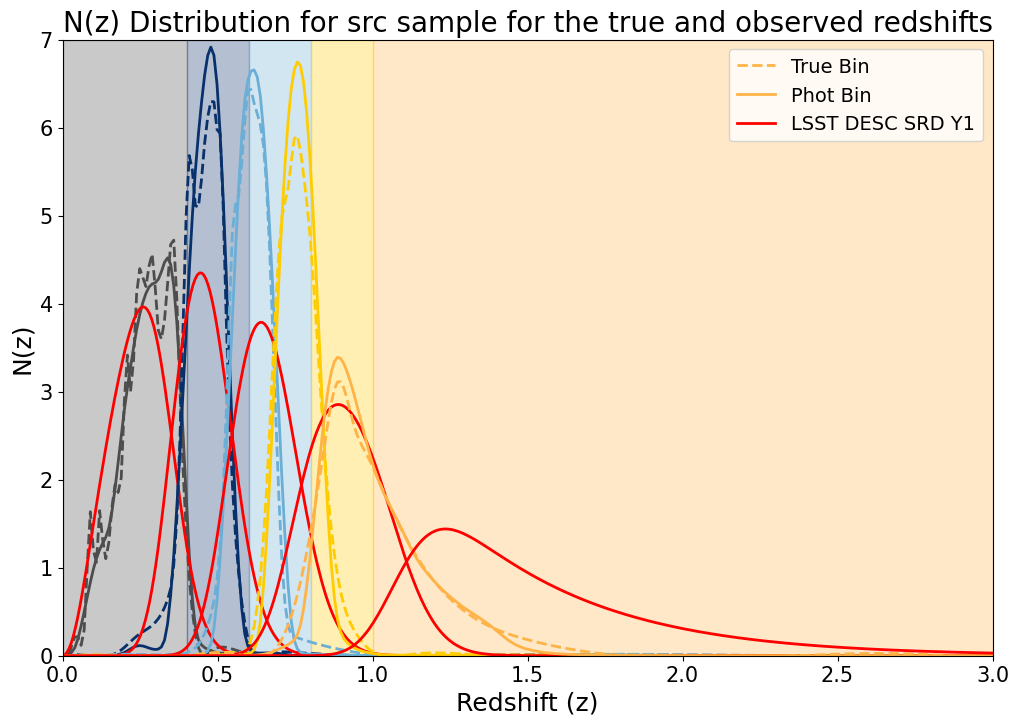

In [12]:
colors = ['#4d4d4d', '#08306b', '#6baed6', '#ffcc00', '#ffb347']

lens_srd = pd.read_csv('/global/u1/i/iago/lens_SRD', sep=' ', index_col=False).T #Change here the location of SRD lens file
bins = [float(x) for x in np.array(lens_srd.index)]

src_srd=pd.read_csv('/global/u1/i/iago/src_SRD', sep=' ',index_col=False).T
bins = [float(x) for x in np.array(lens_srd.index)]
bins = np.round(np.array(bins),4)

def plot_nz_from_bins(num_bins):
    plt.figure(figsize=(12, 8))  # Create a new figure for plotting
    
    for i, bin_num in enumerate(range(1, num_bins + 1)):
        # Read the data from the HDF5 file
        input_file_true = qp.read(f'true_NZ_true_nz_src_{bin_num}.hdf5')
        input_file_phot = DS.read_file('pdfs_data', QPHandle, 
                      f'single_NZ_naive_stack_src_phot_bin{bin_num-1}.hdf5')
        
        y_true = input_file_true.objdata()['pdfs'][0]
        x_true = input_file_true.metadata()['bins'][0]
        
        y_phot = input_file_phot().build_tables()['data']['yvals'][0]
        x_phot = input_file_phot().build_tables()['meta']['xvals'][0]

        # Smoothing the true curve before normalizing
        cs_true = UnivariateSpline(x_true[:-1], y_true)
        cs_true.set_smoothing_factor(1)  # Adjust the smoothing factor here

        smoothed_y_true = cs_true(x_true[:-1])
        
        # Normalize the area under the smoothed true curve
        area_true = np.trapz(smoothed_y_true, x_true[:-1])
        y_true_normalized = smoothed_y_true / area_true  # Normalized to area 1
        
        # Normalize the area under the photometric curve
        area_phot = np.trapz(y_phot, x_phot)
        y_phot_normalized = y_phot / area_phot  # Normalized to area 1

        # Plot the photometric and true curves
        plt.plot(x_phot, y_phot_normalized, color=colors[i], linewidth=2)
        plt.plot(x_true[:-1], y_true_normalized, color=colors[i], linestyle='--', linewidth=2)
        plt.plot(bins,src_srd[i],color='red',linewidth=2)
        
        
    plt.axvspan(0, 0.4, color=colors[0], alpha=0.3)  # Primeiro intervalo
    plt.axvspan(0.4, 0.6, color=colors[1], alpha=0.3)  # Segundo intervalo
    plt.axvspan(0.6, 0.8, color=colors[2], alpha=0.3)  # Terceiro intervalo
    plt.axvspan(0.8, 1.0, color=colors[3], alpha=0.3)  # Quarto intervalo
    plt.axvspan(1.0, 3, color=colors[4], alpha=0.3)  # Quinto intervalo
      
    
    plt.plot([],[], label=f'True Bin',linewidth=2,ls='--',color=colors[i])
    plt.plot([],[], label=f'Phot Bin',linewidth=2,color=colors[i])
    plt.plot([],[], label=f'LSST DESC SRD Y1',linewidth=2,color='red')
        
    # Customizing the plot
    plt.xlabel('Redshift (z)', fontsize=18)
    plt.ylabel('N(z)', fontsize=18)
    plt.title('N(z) Distribution for src sample for the true and observed redshifts',fontsize=20)
    plt.legend(fontsize=14,loc=1)
    plt.ylim(0, 7)  # Adjusted for normalized values
    plt.xlim(0, 3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# Call the function to plot N(z) for 5 bins
plot_nz_from_bins(num_bins=5)
